# Predicting 5hmC values using oxBS and WGBS

In [38]:
from Checkpoints import Checkpoint

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
def subtractionMethod(wgbs, comp):
    merged = pd.merge(wgbs, comp, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
    if comp.columns.__contains__("percentMeth_oxBS_5mC"):
        merged["percentMeth_subtraction_5hmC"] = merged["percentMeth_WGBS"].subtract(merged["percentMeth_oxBS_5mC"])
    elif comp.columns.__contains__("percentMeth_TAB_5hmC"):
        merged["percentMeth_subtraction_5mC"] = merged["percentMeth_WGBS"].subtract(merged["percentMeth_TAB_5hmC"])
    return merged

sub_hmc = subtractionMethod(two_mod_wide, mc_df_wide)
sub_mc = subtractionMethod(two_mod_wide, hmc_df_wide)
sub_hmc_compare = pd.merge(sub_hmc, hmc_df_wide, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
sub_mc_compare = pd.merge(sub_mc, mc_df_wide, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
sub_hmc_compare

In [ ]:
from scipy import stats
from graphing import linePlot

stats.pearsonr(sub_hmc_compare["percentMeth_subtraction_5hmC"], sub_hmc_compare["percentMeth_Nanopore_5hmC"])
fig, ax = plt.subplots()

sns.set_palette("tab10")

ax.plot(np.arange(0, 101, 1), "black", linestyle=":")
linePlot(sub_mc_compare, ax)
linePlot(sub_mc_compare, ax, True)

# MLML comparison

In [ ]:
import numpy as np 

three_mod_bis = pd.read_csv('./DNMTools_datasets/dnmtoolsMLML_output.txt', sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"])
three_mod_nano = pd.read_csv('./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed', sep="\t", 
                             names=["chromosome", "chromStart", "chromEnd", "modification_type", "score", "strand", "i0", "i1", "i2", "readCount_ALL", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

three_mod_nano["readCount"] = three_mod_nano["readCount_ALL"].subtract(
    np.add(three_mod_nano["N_filt"], three_mod_nano["N_NA"])
)

three_mod_nano = three_mod_nano.drop(columns=["modification_type", "score", "i0", "i1", "i2", "readCount_ALL", "N_filt", "N_NA"])

three_mod_nano["percentMeth_C"] = three_mod_nano["N_C"].divide(three_mod_nano["readCount"], axis=0)
three_mod_nano["percentMeth_hmC"] = three_mod_nano["N_hmC"].divide(three_mod_nano["readCount"], axis=0)
three_mod_nano["percentMeth_mC"] = three_mod_nano["N_mC"].divide(three_mod_nano["readCount"], axis=0)

three_mod_nano.replace(np.nan, 0)
three_mod_nano = three_mod_nano.loc[three_mod_nano["readCount"] >= 10]
three_mod_nano.drop(columns=["N_C", "N_mC", "N_hmC", "readCount"], inplace=True)

In [ ]:
merged_three_mod = pd.merge(three_mod_bis, three_mod_nano, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Nanopore"])

# hMeDIP Comparison

In [ ]:
from common import *
import pandas as pd

hmedip_seq = pd.read_csv("../../data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_modified_bases.bed", sep="\t", 
                         names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"]).query("readCount > 0")

1. How many CpGs, of all CpGs, are hydroxymethylated in the IP vs. WGS?

In [ ]:
if not "wgs" in locals():
    wgs = pd.read_csv("./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed", sep="\t", 
                      names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

ip_ratio, wgs_ratio = hmedip_seq["N_hmC"].sum()/hmedip_seq["readCount"].sum(), wgs["N_hmC"].sum()/wgs["readCount"].sum()

print(f"IP: {ip_ratio}, WGS: {wgs_ratio}, IP/WGS: {round(ip_ratio/wgs_ratio, 3)}")

IP: 0.17132278207167603, WGS: 0.07351447326456936, IP/WGS: 2.33


2. What features are enriched in the IP vs. WGS? 

In [ ]:
import pyranges
from CpGIntersects import geneFeatureRefPyRange

hmedip_seq_pr = pyranges.PyRanges(hmedip_seq.rename(columns={"chromosome" : "Chromosome", "chromStart" : "Start", "chromEnd" : "End"}))
wgs_pr = pyranges.PyRanges(wgs.rename(columns={"chromosome" : "Chromosome", "chromStart" : "Start", "chromEnd" : "End"}))

ref_pr = geneFeatureRefPyRange().unstrand()

In [ ]:
ip_feats = hmedip_seq_pr.join(ref_pr, strandedness=None).as_df()
wgs_feats = wgs_pr.join(ref_pr, strandedness=None).as_df()

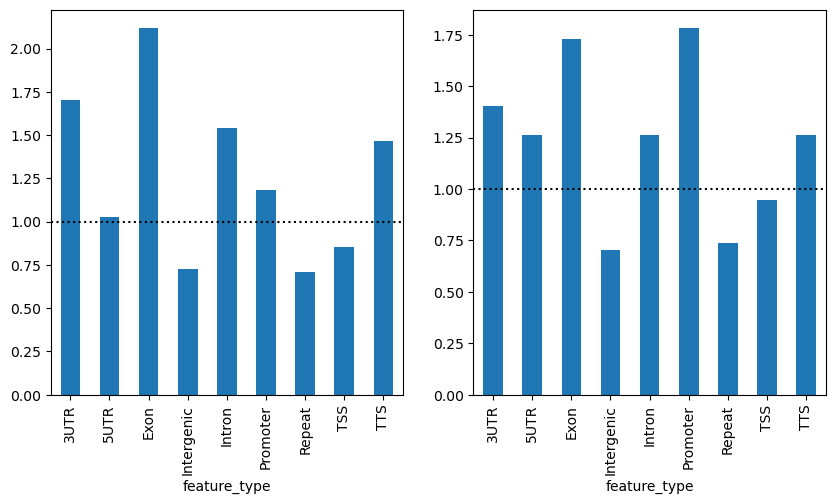

In [ ]:
fig, axes = plt.subplots(nrows= 1, ncols=2, figsize=(10, 5))

for index, data in enumerate(["readCount", "N_hmC"]):
    ip_feats_ratios = ip_feats.groupby("feature_type")[data].sum()/ip_feats[data].sum()
    wgs_feats_ratios = wgs_feats.groupby("feature_type")[data].sum()/wgs_feats[data].sum()
    feat_makeup = ip_feats_ratios/wgs_feats_ratios
    feat_makeup.plot.bar(ax=axes[index])
    axes[index].axhline(1.0, ls=":", c="black")

Genic elements are enriched in the IP data relative to WGS in terms of raw coverage. 

Promoters, and to a smaller degree genic elements, are overrepresented as a proportion of all 5hmC calls relative to WGS. 

3. What proportion of all reads are hydroxymethylated? 

In [21]:
from modbampy import ModBam
import pandas as pd
from common import *

ip_bam_path = "../../data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_basecalls_sorted.bam"
    
def allCpGsInModBam(path):
    with ModBam(path) as bam:
        pos_all = []
        for locus in loadChromSize().to_dict("index").values():
            for read in bam.reads(locus["chromosome"], locus["chromStart"], locus["chromEnd"]):
                [pos_all.append([locus["chromosome"], locus["chromEnd"], *pos_mod]) for pos_mod in read.mod_sites]

    ps_df = pd.DataFrame(pos_all).drop(columns=[1, 5, 6, 7]).rename(columns={0 : "chromosome",
                                                                         2 : "readID",
                                                                         3 : "refPos", 
                                                                         4 : "qPos",                                                            
                                                                         8 : "modBase", 
                                                                         9 : "modScore"}).query("refPos != -1")

    return ps_df

def subsampleCpGsInModBam(path, subsample_size):
    with ModBam(path) as bam:
        pos_all = []
        read_count = 0 
        for locus in loadChromSize().to_dict("index").values():
            if read_count == subsample_size:
                break
            for read in bam.reads(locus["chromosome"], locus["chromStart"], locus["chromEnd"]):
                if read_count == subsample_size:
                    break
                [pos_all.append([locus["chromosome"], locus["chromEnd"], *pos_mod]) for pos_mod in read.mod_sites]
                read_count += 1

    ps_df = pd.DataFrame(pos_all).drop(columns=[1, 5, 6, 7]).rename(columns={0 : "chromosome",
                                                                         2 : "readID",
                                                                         3 : "refPos", 
                                                                         4 : "qPos",                                                            
                                                                         8 : "modBase", 
                                                                         9 : "modScore"}).query("refPos != -1")

    return ps_df

def pivotToReads(cpg_df):
    pps_df = cpg_df.pivot(columns="modBase", index=["chromosome", "readID", "refPos"], values="modScore")
    pps_df.loc[pps_df.loc[:, "m"] <= (0.66*255), "m"], pps_df.loc[pps_df.loc[:, "m"] >= (0.66*255), "m"] = 0, 1
    pps_df.loc[pps_df.loc[:, "h"] <= (0.66*255), "h"], pps_df.loc[pps_df.loc[:, "h"] >= (0.66*255), "h"] = 0, 1
    
    return pps_df

def aggregateCpGsInReads(pivoted_df):
    agg_reads = pivoted_df.groupby(["readID"]).aggregate({"h" : sum,
                                                          "m" : sum})

    return agg_reads

In [22]:
ip_reads = allCpGsInModBam(ip_bam_path)

In [ ]:
ip_reads = aggregateCpGsInReads(pivotToReads(allCpGsInModBam(ip_bam_path)))

In [ ]:
len(ip_reads.loc[ip_reads.loc[:, 'h'] > 0])

229004

In [ ]:
print(f"{len(ip_reads.loc[ip_reads.loc[:, 'h'] > 0])} ({round(len(ip_reads.loc[ip_reads.loc[:, 'h'] > 0])/len(ip_reads), 3)*100}%) mapped reads contain 5hmC.")

229004 reads (47.4%) reads contain 5hmC.


4. How many 5hmCpGs per read? 

In [ ]:
ip_reads["h"].mean() # just under 1 5hmCpG per read

0.8930224850600188

<Axes: ylabel='Frequency'>

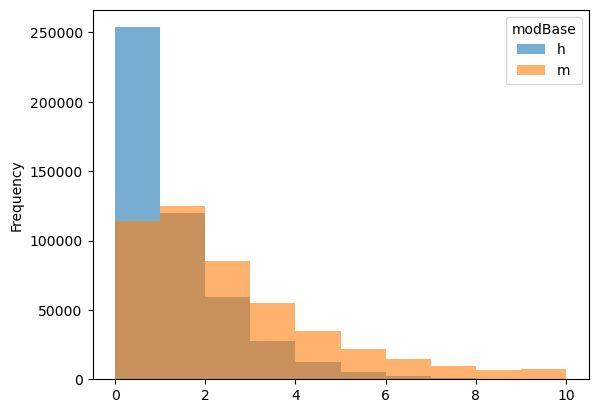

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

ip_reads.plot.hist(histtype='bar', alpha=0.6, stacked=False, bins=10, range=(0, 10), ax=ax)

5. How does this compare to WGS? 

In [ ]:
from modbampy import ModBam

wgs_bam_path = "../../data/cbm1_wgs_26_06_23/dorado_0.3.1_basecalls/sorted/cbm1_wgs_26_06_23_merged.bam"

with ModBam(wgs_bam_path) as bam:
    pos_all = []
    read_count = 0
    for locus in loadChromSize().to_dict("index").values():
        if read_count == 10000:
            break
        for read in bam.reads(locus["chromosome"], locus["chromStart"], locus["chromEnd"]):
            if read_count == 10000:
                break
            [pos_all.append([locus["chromosome"], locus["chromEnd"], *pos_mod]) for pos_mod in read.mod_sites]
            print(f"Reads counted: {read_count}")
            read_count += 1

Reads counted: 0
Reads counted: 1
Reads counted: 2
Reads counted: 3
Reads counted: 4
Reads counted: 5
Reads counted: 6
Reads counted: 7
Reads counted: 8
Reads counted: 9
Reads counted: 10
Reads counted: 11
Reads counted: 12
Reads counted: 13
Reads counted: 14
Reads counted: 15
Reads counted: 16
Reads counted: 17
Reads counted: 18
Reads counted: 19
Reads counted: 20
Reads counted: 21
Reads counted: 22
Reads counted: 23
Reads counted: 24
Reads counted: 25
Reads counted: 26
Reads counted: 27
Reads counted: 28
Reads counted: 29
Reads counted: 30
Reads counted: 31
Reads counted: 32
Reads counted: 33
Reads counted: 34
Reads counted: 35
Reads counted: 36
Reads counted: 37
Reads counted: 38
Reads counted: 39
Reads counted: 40
Reads counted: 41
Reads counted: 42
Reads counted: 43
Reads counted: 44
Reads counted: 45
Reads counted: 46
Reads counted: 47
Reads counted: 48
Reads counted: 49
Reads counted: 50
Reads counted: 51
Reads counted: 52
Reads counted: 53
Reads counted: 54
Reads counted: 55
Re

In [ ]:
ps_df = pd.DataFrame(pos_all).drop(columns=[1, 5, 6, 7]).rename(columns={0 : "chromosome",
                                                                         2 : "readID",
                                                                         3 : "refPos", 
                                                                         4 : "qPos",                                                            
                                                                         8 : "modBase", 
                                                                         9 : "modScore"}).query("refPos != -1")
wgs_subsample = aggregateCpGsInReads(pivotToReads(ps_df))

In [ ]:
print(f"{len(wgs_subsample.loc[wgs_subsample.loc[:, 'h'] > 0])} ({round(len(wgs_subsample.loc[wgs_subsample.loc[:, 'h'] > 0])/len(wgs_subsample), 3)*100}%) mapped reads contain 5hmC.")

6120 (61.6%) mapped reads contain 5hmC.


This may not be meaningful - the N50 of the IP sample is only 564 bp, vs. 5 kb for the WGS. 

6. When filtered to non-repeat elements? 

In [ ]:
import pyranges as pr
from CpGIntersects import geneFeatureRefPyRange

def makePyRangeFromModbamCpGs(modbam_cpgs):
    pyrangeable_df = modbam_cpgs.reset_index()
    pyrangeable_df.rename(columns={"chromosome" : "Chromosome",
                                   "refPos" : "Start"},
                          inplace=True)
    pyrangeable_df["End"] = pyrangeable_df["Start"].add(1)
    return pr.PyRanges(pyrangeable_df[["Chromosome", "Start", "End", "readID", "h", "m"]])


In [ ]:
ip_cpgs = pivotToReads(allCpGsInModBam(ip_bam_path))

In [ ]:
ip_cpgs_feat = makePyRangeFromModbamCpGs(ip_cpgs).join(geneFeatureRefPyRange().unstrand(), strandedness=None).as_df()

In [ ]:
ip_cpgs_feat.loc[(ip_cpgs_feat.loc[:, "feature_type"] != "Repeat")].groupby("readID").aggregate({"h" : sum, "m" : sum})["h"].mean()

0.9763383840999244

# Generating mlml-compatible datasets

In [ ]:
from common import *
import pandas as pd

wgbs_bed_path = './data/WGBS_data/mm39_ENCSR893RHD_merged.bed'
wgbs_df = get_wgbs(wgbs_bed_path)

oxbs_bed_path = './data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed' 
oxbs_df = get_bismark(oxbs_bed_path, "5mC")

tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
tab_df = get_bismark(tab_bed_path, "5hmC")

In [ ]:
bisulphite_merged = filterDepth(wgbs_df).merge(
    filterDepth(oxbs_df), "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_oxBS"]).merge(
        filterDepth(tab_df), "inner", ["chromosome", "chromStart", "chromEnd"]
        )
bisulphite_merged["context"] = "CPG"
bisulphite_merged.loc[:, ("percentMeth_WGBS", "percentMeth_oxBS", "percentMeth")] = bisulphite_merged.loc[:, ("percentMeth_WGBS", "percentMeth_oxBS", "percentMeth")].divide(100)

In [ ]:
bisulphite_merged.loc[:, ("chromosome", "chromStart", "strand", "context", "percentMeth_WGBS", "readCount_WGBS")].to_csv("./DNMTools_datasets/mm39_ENCSR893RHD_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)
bisulphite_merged.loc[:, ("chromosome", "chromStart", "strand", "context", "percentMeth_oxBS", "readCount_oxBS")].to_csv("./DNMTools_datasets/mm39_oxBS_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)
bisulphite_merged.loc[:, ("chromosome", "chromStart", "strand", "context", "percentMeth", "readCount")].to_csv("./DNMTools_datasets/mm39_TAB_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)

In [ ]:
import pyranges as pr

ip_pr = pr.read_bam("../../data/cbm1_ip_13_07_23/dorado_0.3.1_basecalls_raw/cbm1_ip_13_07_23_basecalls.bam")

In [ ]:
ip_df = ip_pr.merge(strand=None, slack=0, count=True).as_df()

In [ ]:
ip_df.sort_values("Count", ascending=False)

,Chromosome,Start,End,Strand,Count
320210,chr9,3000002,3026813,+,11604
337054,chr9,3000002,3019452,-,6990
58043,chr2,98496883,98497681,+,6208
81621,chr2,98496885,98497681,-,6123
624110,chrUn_JH584304v1,73552,98561,+,4205
...,...,...,...,...,...
228216,chr6,124349756,124349995,+,1
228217,chr6,124356125,124356525,+,1
228218,chr6,124380078,124380358,+,1
228219,chr6,124386153,124386469,+,1


# MinION WGS Comparison

1. What is the approximate depth of the sample and how many CpGs are of sufficient depth? 

In [ ]:
minion_cpgs_raw = pd.read_csv("./data/Nanopore_ternary_data/cbm1_wgs_26_06_23_modified-bases.bed", sep="\t", 
                         names=["chromosome", "chromStart", "chromEnd", "mod_type", "score", "strand", "i1", "i2", "i3", "readCount", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

In [ ]:
minion_cpgs_raw["N_hmC"].sum()/minion_cpgs_raw["readCount"].sum()

0.06503038081598125

In [ ]:
len(minion_cpgs_raw.loc[(minion_cpgs_raw.loc[:, "N_hmC"] > 0)])/len(minion_cpgs_raw)

0.3253704874622543

<Axes: ylabel='Frequency'>

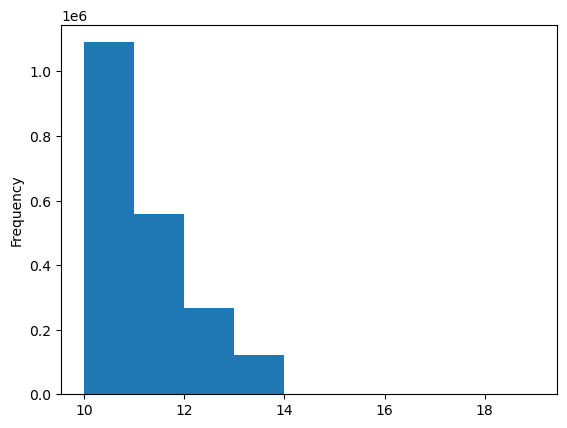

In [ ]:
import numpy as np 
minion_cpgs["readCount_T"].plot.hist(bins=list(np.arange(10, 20, 1)))

2. How well does this compare to the PromethION data? 

In [1]:
import pandas as pd 
from common import *

if not "prom_data" or not "min_data" in locals().keys():
    prom_data = readModbam2bedTernary("../../data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/cbm1_prom_modbases.bed")
    min_data = readModbam2bedTernary("./data/Nanopore_ternary_data/cbm1_wgs_26_06_23_modified-bases.bed")

merged_nanopore = pd.merge(prom_data, min_data, "inner", ["chromosome", "chromStart", "chromEnd", "strand"], suffixes=["_Prom", "_Min"])

In [5]:
from scipy import stats
from sklearn import preprocessing
from sklearn import metrics

print(f"Pearson correlation: {stats.pearsonr(merged_nanopore['percentMeth_hmC_Min'], merged_nanopore['percentMeth_hmC_Prom']).statistic}, Spearman: {stats.spearmanr(merged_nanopore['percentMeth_hmC_Min'], merged_nanopore['percentMeth_hmC_Prom']).statistic}")
binarizer = preprocessing.Binarizer(threshold=5)

x, y = binarizer.fit_transform(merged_nanopore['percentMeth_hmC_Min'].to_numpy().reshape(-1, 1)), binarizer.fit_transform(merged_nanopore['percentMeth_hmC_Prom'].to_numpy().reshape(-1, 1))
metrics.matthews_corrcoef(x, y)

Pearson correlation: 0.5480877522989152, Spearman: 0.43492095652920526


0.29723134932783274

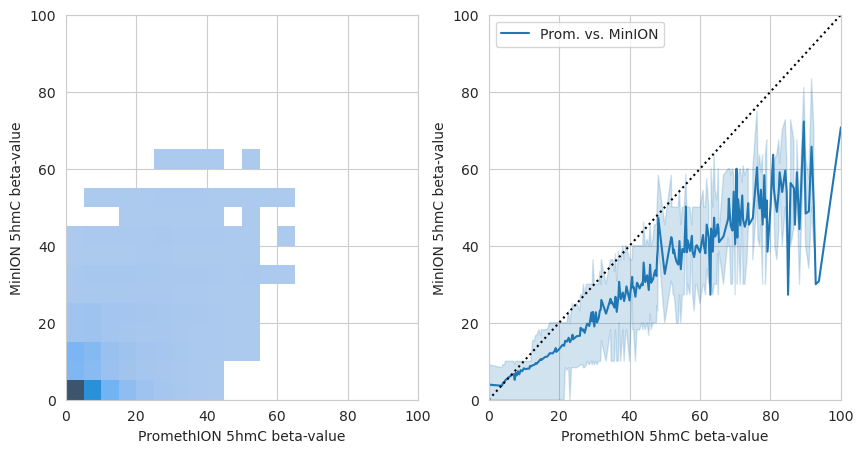

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", stat="proportion", bins=20, pthresh=0.01, ax=axes[0])
sns.lineplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[1], ls="-", label="Prom. vs. MinION")

axes[1].plot(np.arange(0, 101), ls=":", c="black")

for ax in axes:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("MinION 5hmC beta-value")
    ax.set_xlabel("PromethION 5hmC beta-value")


Relative to TAB? 

In [71]:
from Checkpoints import Checkpoint
from common import get_bismark, filterDepth

hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()
tab_df = filterDepth(get_bismark("./data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov", "5hmC"))

min_tab_df = pd.merge(tab_df, min_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_Min"])

Text(0, 0.5, 'Pron. 5hmC beta-value')

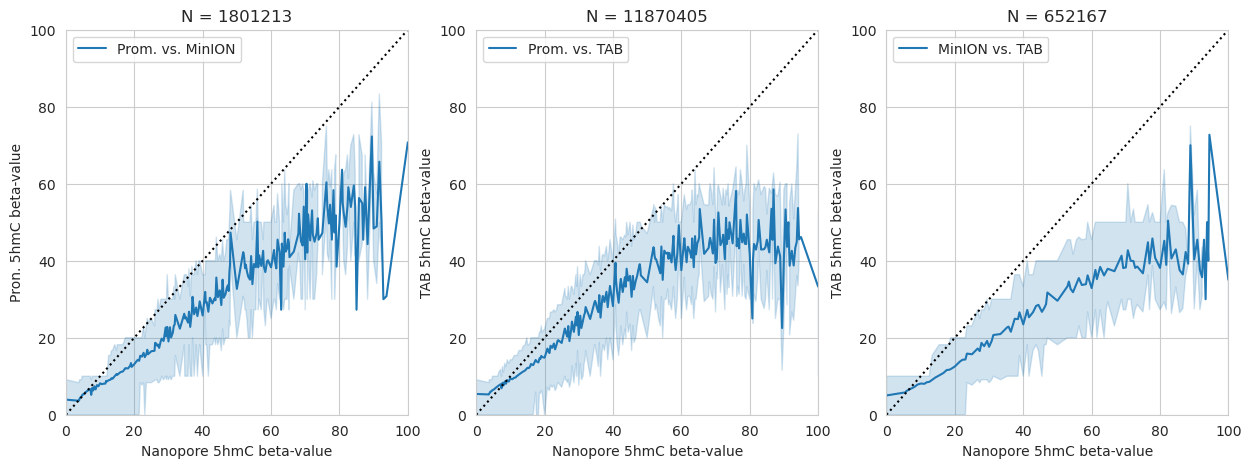

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[0], ls="-", label="Prom. vs. MinION")
sns.lineplot(hmc_df_wide, x="percentMeth_TAB_5hmC", y="percentMeth_Nanopore_5hmC", errorbar=("pi", 50), ax=axes[1], ls="-", label="Prom. vs. TAB")
sns.lineplot(min_tab_df, x="percentMeth", y="percentMeth_hmC", errorbar=("pi", 50), ax=axes[2], ls="-", label="MinION vs. TAB")

for index, ax in enumerate(axes):
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("TAB 5hmC beta-value")
    ax.set_xlabel("Nanopore 5hmC beta-value")
    ax.plot(np.arange(0, 101), ls=":", c="black")
    ax.set_title(f"N = {len([merged_nanopore, hmc_df_wide, min_tab_df][index])}")

axes[0].set_ylabel("Min. 5hmC beta-value")
axes[0].set_ylabel("Pron. 5hmC beta-value")


How does this look resampled? See above.

In [ ]:
from common import optimisedResample

In [ ]:
resampled_min_prom_data = optimisedResample(merged_nanopore, "readCount_T_Prom", "readCount_T_Min")

Most common readcount is 10 with 64847 CpGs.


In [ ]:
stats.pearsonr(resampled_min_prom_data["percentMeth_hmC_Min"], resampled_min_prom_data["percentMeth_hmC_Prom"]), stats.spearmanr(resampled_min_prom_data["percentMeth_hmC_Min"], resampled_min_prom_data["percentMeth_hmC_Prom"])

(PearsonRResult(statistic=0.5035612658206317, pvalue=0.0),
 SignificanceResult(statistic=0.40988852402331627, pvalue=0.0))

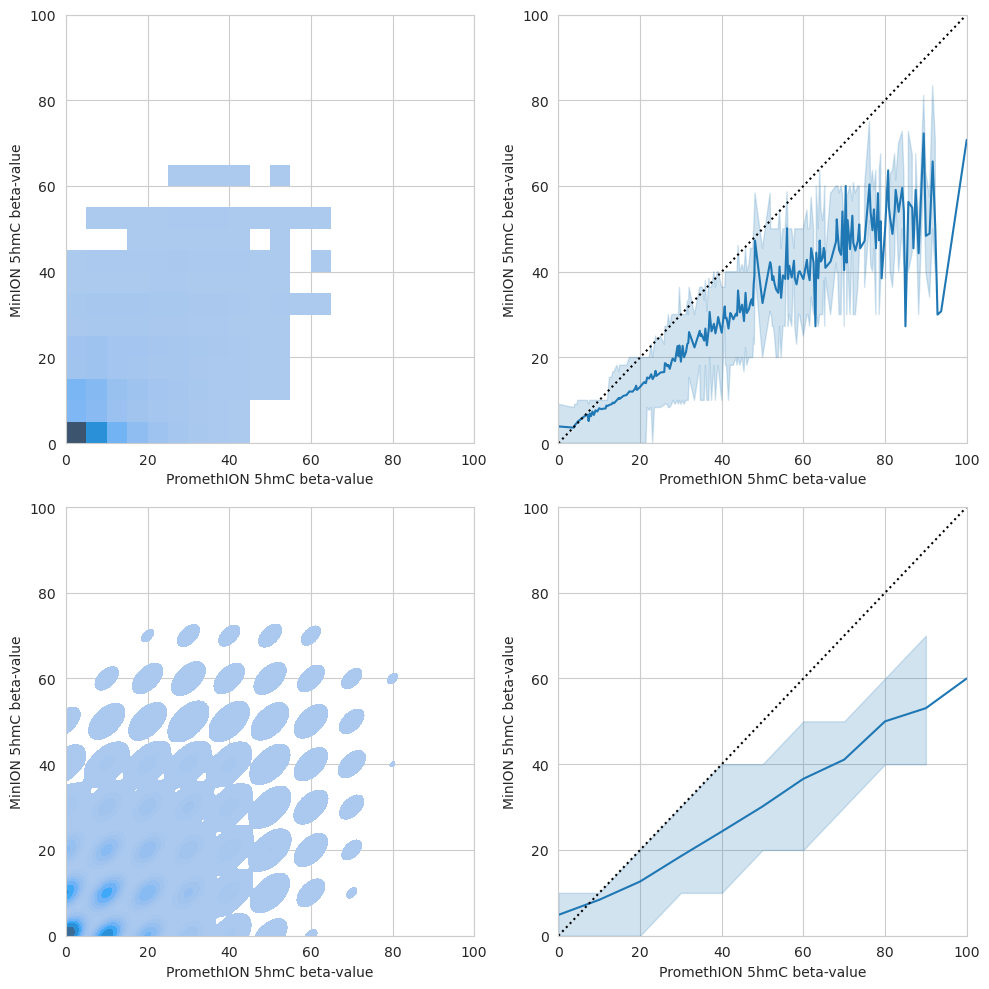

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", stat="proportion", pthresh=0.01, bins=20, ax=axes[0][0])
sns.lineplot(merged_nanopore, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[0][1])
sns.histplot(resampled_min_prom_data, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", stat="proportion", pthresh=0.01, bins=10, ax=axes[1][0])
sns.lineplot(resampled_min_prom_data, x="percentMeth_hmC_Prom", y="percentMeth_hmC_Min", errorbar=("pi", 50), ax=axes[1][1])
axes[0][1].plot(np.arange(0, 101), ls=":", c="black")
axes[1][1].plot(np.arange(0, 101), ls=":", c="black")

for ax in axes[0]:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("MinION 5hmC beta-value")
    ax.set_xlabel("PromethION 5hmC beta-value")
    
for ax in axes[1]:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, 100)
    ax.set_ylabel("MinION 5hmC beta-value")
    ax.set_xlabel("PromethION 5hmC beta-value")

plt.tight_layout()

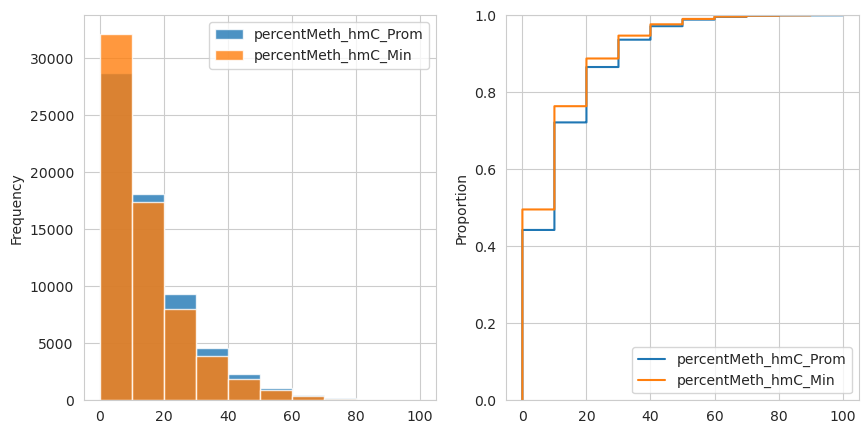

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

resampled_min_prom_data[["percentMeth_hmC_Prom", "percentMeth_hmC_Min"]].plot.hist(alpha=0.8, ax=axes[0])

for col in ["percentMeth_hmC_Prom", "percentMeth_hmC_Min"]:
    sns.ecdfplot(resampled_min_prom_data, label=col, x=col, ax=axes[1])
axes[1].set_xlabel(None)
axes[1].legend()

In [ ]:
stats.ttest_ind(resampled_min_prom_data["percentMeth_hmC_Prom"], resampled_min_prom_data["percentMeth_hmC_Min"])

Ttest_indResult(statistic=18.610082692905646, pvalue=3.3576436738670598e-77)

In [ ]:
merged_wgbs_oxbs_wTAB = pd.merge(merged_wgbs_oxbs, tab_df, "inner", ["chromosome", "chromStart", "chromEnd"])

In [ ]:
merged_wgbs_oxbs_wTAB.loc[merged_wgbs_oxbs_wTAB["percentMeth_Subtraction_5hmC"] < 0, "percentMeth_Subtraction_5hmC"] = 0

In [ ]:
from scipy import stats

r = stats.pearsonr(merged_wgbs_oxbs_wTAB["percentMeth_Subtraction_5hmC"], merged_wgbs_oxbs_wTAB["percentMeth"])[0]

In [ ]:
merged_wgbs_oxbs_wTAB["bench_bin"] = pd.cut(merged_wgbs_oxbs_wTAB["percentMeth"], 51, labels=np.arange(0, 102, 2))

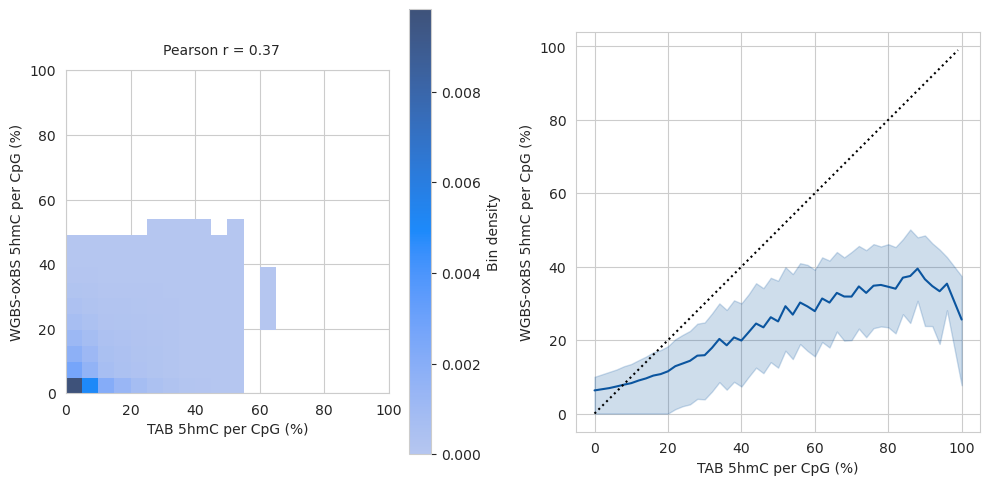

In [ ]:
from scipy import stats
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
# sns.set_palette("Blues_r")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax = fig.add_subplot(gs[0, 0])

sns.histplot(merged_wgbs_oxbs_wTAB, x="percentMeth", y="percentMeth_Subtraction_5hmC", bins=20, pthresh=0.01, stat="density", cbar=True, cbar_kws={"label" : "Bin density"}, ax=ax)
ax.text(30, 105, "Pearson r = {r:.2f}".format(r=(r), ha="center"))
ax.set_xlim((0, 100))
ax.set_ylim((0, 100))
ax.set_ylabel("WGBS-oxBS 5hmC per CpG (%)")
ax.set_xlabel("TAB 5hmC per CpG (%)")
ax.set_aspect("equal")

ax2 = fig.add_subplot(gs[0, 1])
sns.lineplot(merged_wgbs_oxbs_wTAB, x="bench_bin", y="percentMeth_Subtraction_5hmC", errorbar=("pi", 50), ax=ax2)
ax2.plot(np.arange(0, 100), color="black", linestyle=":")
ax2.set_ylabel("WGBS-oxBS 5hmC per CpG (%)")
ax2.set_xlabel("TAB 5hmC per CpG (%)")
ax2.set_aspect("equal")

fig.tight_layout()


# Testing with MAPQ filtering

Raw data comparison is weak. Is it possible that comparison is not between like CpG sites, due to ambiguous mapping? 

In [2]:
from common import readModbam2bedTernary, get_bismark, filterDepth

high_mapq_prom = readModbam2bedTernary("../../data/prom_R10.4.1_E8.2_WGS_brain_DH/dorado_0.3.2_basecalls/cbm1_prom_modbases_mapq60.bed")
tab_data = filterDepth(get_bismark("./data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov", "5hmC"))

In [5]:
import pandas as pd
promQ60_tab = pd.merge(high_mapq_prom, tab_data, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Promq60", "_TAB"])

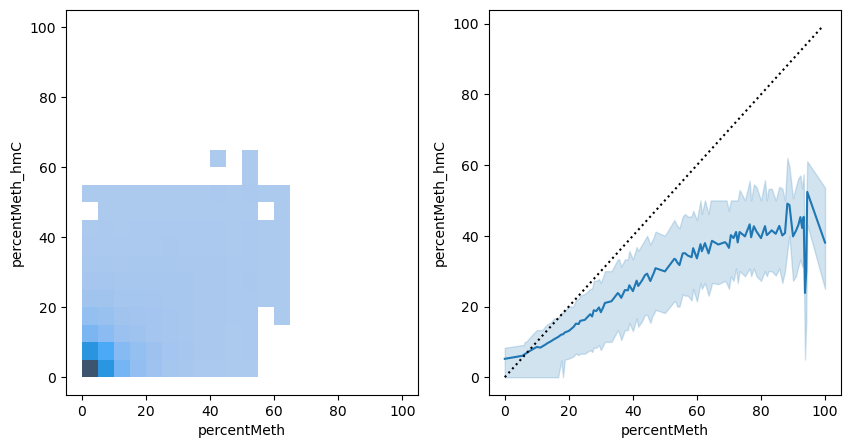

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(promQ60_tab, x="percentMeth", y="percentMeth_hmC", bins=20, pthresh=0.01, ax=axes[0])
sns.lineplot(promQ60_tab, x="percentMeth", y="percentMeth_hmC", errorbar=("pi", 50), ax=axes[1])
axes[1].plot(np.arange(0, 100, 1), color="black", ls=":")

In [13]:
from scipy import stats

x, y = promQ60_tab.loc[:, "percentMeth"], promQ60_tab.loc[:, "percentMeth_hmC"]
pearson, spearman = stats.pearsonr(x, y).statistic, stats.spearmanr(x, y).statistic

print(f"Pearson: {pearson}; Spearman: {spearman}")

Pearson: 0.5459902258471043; Spearman: 0.4327363763317448


# Peak calling

1. Peaks are called as follows:

First, `bedtools genomecov` is used to produce a bedgraph format output of the coverage of all genomic positions (positions of zero depth are inferred from gaps). 
Then, the script below uses this bedgraph output to write a new file, with blocks of coverage merged, taking the maximum coverage depth for each block.


In [ ]:
import csv

with open("../../data/cbm1_ip_13_07_23/cbm1_ip_13_07_23_coverage.bedgraph", newline="", mode="rt") as depth_file, open("../../data/cbm1_ip_13_07_23/peaks.bedgraph", "wt") as new_file:
    reader = csv.reader(depth_file, delimiter="\t")
    writer = csv.writer(new_file, delimiter="\t")
    # row_count = 0
    row = next(reader)

    chrom = row[0]
    start = row[1]
    end = row[2]
    depth = row[3]
    current_peak = [chrom, start, end, depth]

    for row in reader:        
        if int(row[1]) in range(int(end) - 10, int(end) + 10): # if the start of the next line is approximately equal to the end of the previous
            end = row[2] # the end of the peak is updated
            start = start
            if row[3] > depth:
                depth = row[3] # the highest depth is taken
            current_peak = [chrom, start, end, depth]
        else:
            writer.writerow(current_peak)
            chrom = row[0]
            start = row[1]
            end = row[2]
            depth = row[3]
            current_peak = [chrom, start, end, depth] # current_peak is reset to None

I also wrote another script to perform a similar output using the output from `samtools depth`. Importantly, this allows the `-q` option, specifying a minimum required mapping quality (MAPQ). The file below has a mapping quality threshold of 60 (Phred 60 implies a 1/1,000,000 miscalled base probability). 

In [ ]:
with open("../../data/cbm1_ip_13_07_23/samtools_depth_ip.tsv", newline="", mode="rt") as depth_file, open("../../data/cbm1_ip_13_07_23/quality_peaks.bedgraph", "wt") as new_file:
    reader = csv.reader(depth_file, delimiter="\t")
    writer = csv.writer(new_file, delimiter="\t")

    row = next(reader)

    chrom = row[0]
    start = row[1]
    end = int(start) + 1
    depth = row[2]

    for row in reader:
        if int(row[1]) in range(int(end) - 10, int(end) + 10):
            end = row[1]
            if row[2] > depth:
                depth = row[2]
            current_peak = [chrom, start, end, depth]
        else: 
            writer.writerow(current_peak)
            chrom = row[0]
            start = row[1]
            end = int(start) + 1
            depth = row[2]



2. Quantify peaks and sort by coverage depth:

Here: the peak output of the function above is checked, sorted by coverage depth, and filtered to the best alignments. Some high coverage depth alignments were manually checked using IGV and found to align entirely to satellite repeats; these were filtered out on the possibility that they represent ambiguous alignments. 

In [14]:
import pandas as pd
ip_depth_file = pd.read_csv("../../data/cbm1_ip_13_07_23/quality_peaks.bedgraph", sep="\t", names=["chromosome", "start", "end", "depth"])

ip_depth_file_filtered = ip_depth_file.loc[(ip_depth_file.loc[:, "depth"] > 4) & (ip_depth_file.loc[:, "depth"] < 10)]

3. Of the top 25 peaks - what is the CpG prevalence? 

First, I selected only the 25 highest depth peaks. From these, I use their coordinates to extract fasta sequences from the mouse (mm39) reference genome using `samtools faidx`. 

In [15]:
top_25 = ip_depth_file_filtered.nlargest(25, columns="depth")

In [20]:
ip_depth_file_filtered.loc[(ip_depth_file_filtered.loc[:, "depth"] > 6) & (ip_depth_file_filtered.loc[:, "depth"] < 10)]

,chromosome,start,end,depth
8387,chr1,64579113,64579836,7
9975,chr1,75363456,75364071,7
10052,chr1,75550182,75550840,7
13028,chr1,93000416,93001288,7
13038,chr1,93024893,93025627,7
...,...,...,...,...
379829,chrUn_MU069435v1,13299,14412,7
379831,chrUn_MU069435v1,29715,31010,8
392007,chrX,169088624,169089150,9
392010,chrX,169092377,169094046,8


In [19]:
ip_depth_file_filtered.sort_values("depth", ascending=False)

,chromosome,start,end,depth
379759,chrM,10761,16299,9
318790,chr7,24705825,24706737,9
172622,chr18,25664926,25665567,9
225803,chr3,27744102,27744803,9
358617,chr9,3000003,3001928,9
...,...,...,...,...
157785,chr17,26650465,26651187,5
157707,chr17,26285578,26286071,5
157573,chr17,25852978,25853775,5
157369,chr17,24913812,24914703,5


In [ ]:
addresses = top_25[["chromosome", "start", "end"]].apply(func = lambda row: row["chromosome"] + ":" + str(row["start"]) + "-" + str(row["end"]), axis="columns")
addresses.to_csv("./outputs/top_25_ipDepths.tsv", index=False, header=False)

In [44]:
from Bio import SeqIO

sequences = SeqIO.parse(open("./outputs/top_25_ipDepth_sequences.fa"), "fasta")
seq_dict = {}
for fa in sequences: 
    id = fa.id
    seq = str(fa.seq)
    cpg_count = seq.count("CG")
    seq_len = len(seq)
    fa_entry = {
        id : {
        "Length" : seq_len,
        "Count" : cpg_count,
        "Density" : (cpg_count/seq_len)*100
        }
        }
    seq_dict.update(fa_entry)
seq_df = pd.DataFrame().from_dict(seq_dict, "index")


In [45]:
seq_df["Density"].mean()

2.34189893568836

This implies the average CpG count per 100 bases of the each peak is only 2.28. Over the 50th percentile relative to the human genome (Beck *et al.* 2022; https://doi.org/10.1080%2F15592294.2021.1924970) but not high density. 

Below, a sliding window function is used to calculate the maximum CpG density over 100bp windows. 

In [43]:
top_25["length"] = top_25.loc[:, "end"] - top_25.loc[:, "start"]

In [4]:
def slidingWindow(seq, window_size):
    seq_list = list(seq)
    window_list = []
    for i in range(len(seq_list)-window_size):
        window = ("".join(seq_list[i:i+window_size]))
        window_list.append(window)
    return window_list

In [5]:
sequences = SeqIO.parse(open("./outputs/top_25_ipDepth_sequences.fa"), "fasta")
max_dict = {}
window_dict = {}
for fa in sequences: 
    id = fa.id
    seq = str(fa.seq)
    max_count = 0
    window_counts = []
    for window in slidingWindow(seq, 100):
        window_count = window.upper().count("CG")
        window_counts.append(window_count)
        if window_count > max_count:
            max_count = window_count
    max_counts_entry = {
        id : max_count
    }
    max_dict.update(max_counts_entry)
    window_dict_entry = {
        id : window_counts
    }
    window_dict.update(window_dict_entry)

In [9]:
max_counts_df = pd.DataFrame().from_dict(max_dict, orient="index", columns=["Count"]).sort_values("Count", ascending=False)

In [32]:
max_counts_df["Count"].mean()

7.04

The sequences have a modal peak CpG density of 4 CpGs per 100 bp. This is moderately high. The mean peak CpG density is 6.55. 

<Axes: ylabel='Frequency'>

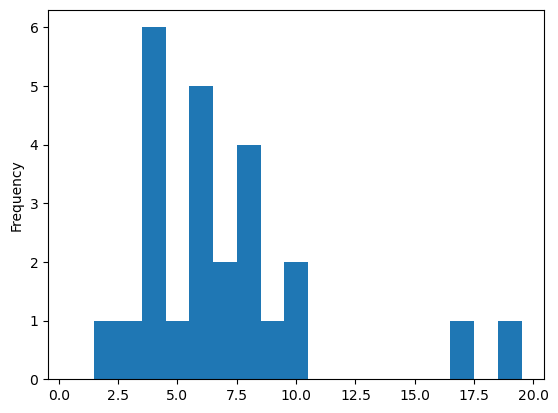

In [34]:
import matplotlib.pyplot as plt
import numpy as np
max_counts_df["Count"].plot.hist(bins=list(range(1, 21)), align="left")

In [59]:
len(window_dict["chr10:84269214-84269758"])

445

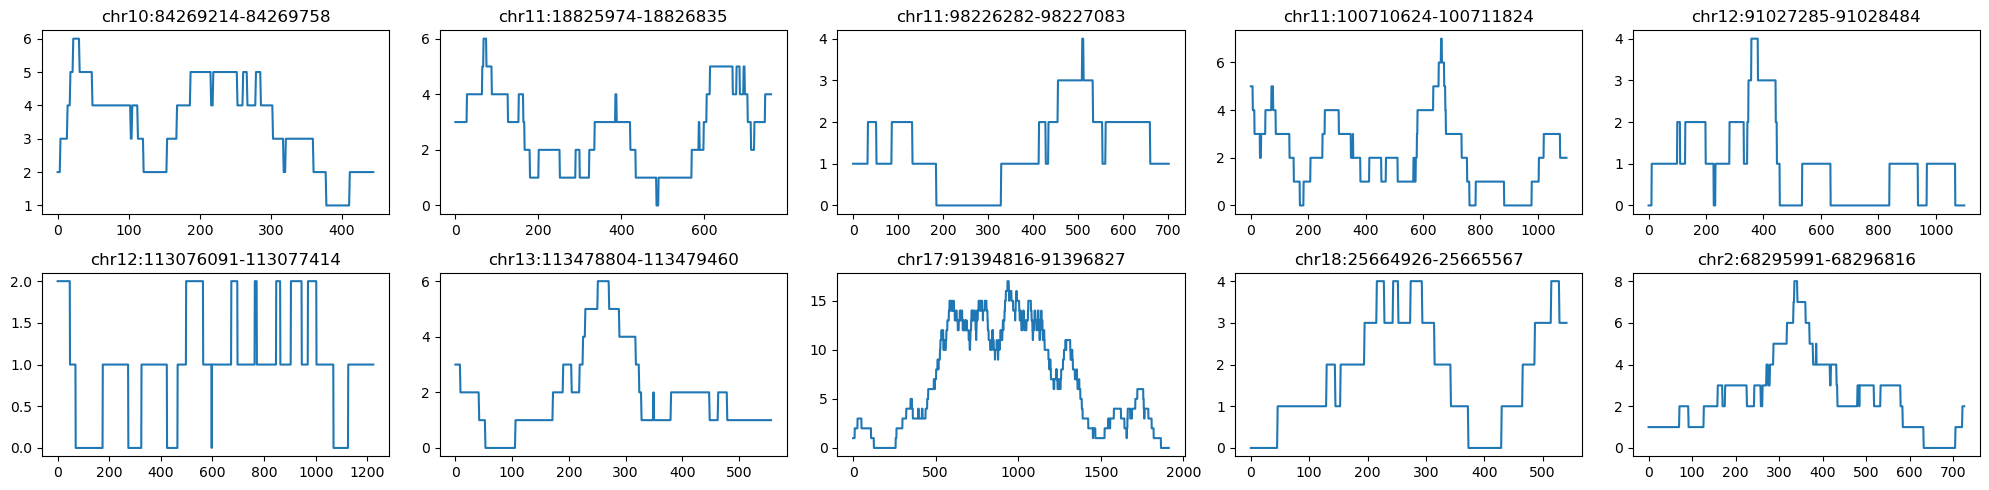

In [8]:
import matplotlib.pyplot as plt

plt.style.use("default")

fig, axes = plt.subplots(2, 5, figsize=(20, 5))

for index, [seq, values] in enumerate(window_dict.items()):
    if index in range(0, 5):
        axes[0][index].plot(values)
        axes[0][index].set_title(seq)
    elif index in range(5, 10):
        axes[1][index-5].plot(values)
        axes[1][index-5].set_title(seq)
    else: 
        break

plt.tight_layout()

How CpG dense is the mouse genome? 

In [39]:
from Bio import SeqIO

mouse_genome_path = "../../data/reference_genomes/mm39/mm39.fa"

mouse_genome = SeqIO.parse(mouse_genome_path, "fasta")

genome_dict = {}
for sequence in mouse_genome:
    seq = str(sequence.seq)
    count = seq.count("CG")
    seq_entry = {
        sequence.id : [count, len(seq), count/len(seq)*100]
    }
    genome_dict.update(seq_entry)

all_chromosomes_df = pd.DataFrame().from_dict(genome_dict, orient="index", columns=["CpG_count", "Length", "Per_100_bp"])

In [41]:
all_chromosomes_df["Length"].sum()

2728222451

In [42]:
all_chromosomes_df["CpG_count"].sum()

13162337

In [43]:
(all_chromosomes_df["CpG_count"].sum()/all_chromosomes_df["Length"].sum())*100

0.48245101843420024

In [50]:
print(f"Peaks are {round(seq_df['Density'].mean()/((all_chromosomes_df['CpG_count'].sum()/all_chromosomes_df['Length'].sum())*100), 2)} enriched for CpGs (per 100bp) relative to the genomic mean.")

Peaks are 4.85 enriched for CpGs (per 100bp) relative to the genomic mean.


# Locus level class definitions

## ConfusionMatrix

In [ ]:
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from Checkpoints import Checkpoint

def merge3Mod(): 
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

    mc_df_wide, hmc_df_wide = map(lambda df: df.drop(columns=["readCount_Bisulphite", "readCount_Nanopore"]), [mc_df_wide, hmc_df_wide])

    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd", "strand"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_TAB_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_oxBS_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

In [ ]:
Checkpoint(merge3Mod()).saveCheckpoint(name="three_state_comparison") 

In [ ]:
hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

# Macro-scale 5hmC analysis

These figures compare 5hmC calling at the level of larger elements, including whole genes and 1kb windows. The focus of these images is on 5hmC - given that this is the modified base with lower apparent classification agreement (see above)

In [ ]:
def threeModDFtohmCPyrange():
    """
    Produces a PyRange object using only the 5hmC comparison data. 
    """
    data = Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint(
        colnames=["chromosome", "chromStart", "chromEnd", "strand", 
                  "percentMeth_Bisulphite_5mC", "percentMeth_Nanopore_5mC", 
                  "percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])
    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange
    
Checkpoint(dataframe=threeModDFtohmCPyrange().as_df(), name="three_mod_pyrange").saveCheckpoint()

In [ ]:
from Checkpoints import Checkpoint

pyrange_data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

## Histograms with feature positions

In [ ]:
from FeatureReferences import Features
from Checkpoints import Checkpoint

repeats = Features('./feature_references/revised/repeats/UCSC_rmsk_mm39_Repeat.bed')
promoters = Features('./feature_references/revised/gene_features/name_adjusted/ENSEMBL_regFeatures_mm39_Promoter_wStrands.bed')

data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

In [ ]:
import pyranges as pr

repeats_data = pr.PyRanges(data).join(pr.PyRanges(repeats.dataframe)).as_df()
promoters_data = pr.PyRanges(data).join(pr.PyRanges(promoters.dataframe)).as_df()

Text(0, 0.5, 'Nanopore enrichment')

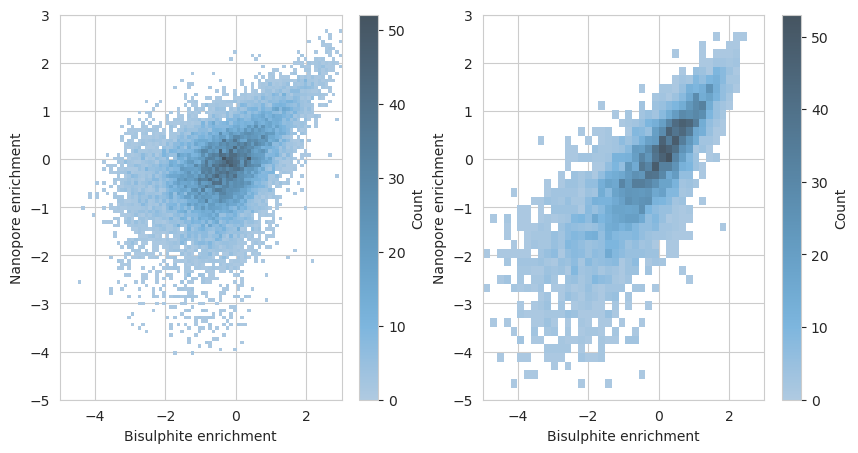

In [ ]:
from GroupCpGs import *
from CpGIntersects import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
sns.set_palette("Blues")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])
FeatureAndGene(CpGIntersects(repeats_data).group("other"), 10).makeHist("count", ax1)
ax1.set_ylim((-5, 3))
ax1.set_xlim((-5, 3))
ax1.set_xlabel("Bisulphite enrichment")
ax1.set_ylabel("Nanopore enrichment")

ax2 = fig.add_subplot(gs[0, 1])
FeatureAndGene(CpGIntersects(promoters_data).group("other"), 10).makeHist("count", ax2)
ax2.set_ylim((-5, 3))
ax2.set_xlim((-5, 3))
ax2.set_xlabel("Bisulphite enrichment")
ax2.set_ylabel("Nanopore enrichment")

Text(0.5, 1.0, 'Repeats')

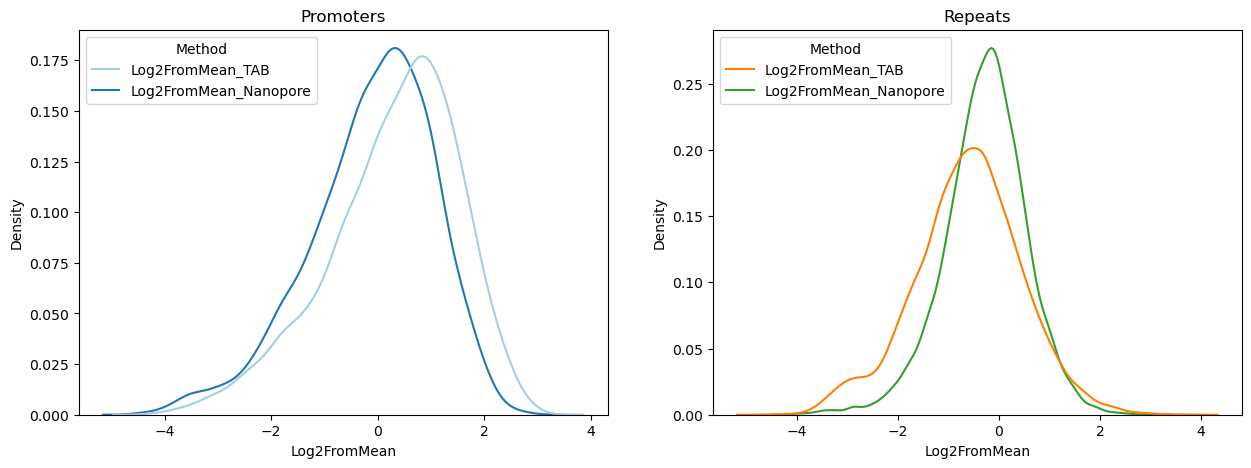

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from GroupCpGs import *

repeats_promoters = pd.concat([FeatureAndGene(CpGIntersects(repeats_data).group("other"), 10).df, 
                               FeatureAndGene(CpGIntersects(promoters_data).group("other"), 10).df])

repeats_promoters = FeatureAndGene(repeats_promoters, 10).dfWithLogCols()
repeats_promoters_melted = repeats_promoters.melt(["Name", "feature_type", "group_start", "group_end"], ["Log2FromMean_TAB", "Log2FromMean_Nanopore"], var_name="Method", value_name="Log2FromMean")

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0), fig=fig)
sns.kdeplot(repeats_promoters_melted.loc[repeats_promoters_melted["feature_type"] == "Promoter"], x="Log2FromMean", hue="Method", palette="Paired", ax=ax1)
ax1.set_title("Promoters")

ax2 = plt.subplot2grid((1, 2), (0, 1), fig=fig)
sns.kdeplot(repeats_promoters_melted.loc[repeats_promoters_melted["feature_type"] == "Repeat"], x="Log2FromMean", hue="Method", palette="Paired_r", ax=ax2)
ax2.set_title("Repeats")


This would indicate that 5hmC is not consistent at each feature. Promoters appear to be more strongly hydroxymethylated (vs. mean) in TAB than Nanopore, and there is a greater tendency for repeat regions to be detected as _more hydroxymethylated_ relative to genomic mean hydroxymethylation in Nanopore than in TAB.

In [ ]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

In [ ]:
# three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

# Read level information at imprinted and non-imprinted sites

These scripts extract read level information from the modified bam files and perform clustering based on CpG site methylation states. The resulting clustermaps help to clearly show CpG sites with similar modification status. 

Of note, CpG sites are here aggregated (merged + and - strands) for ease of visualisation. 

In [ ]:
from modbampy import ModBam
import pandas as pd
import pyranges as pr
import numpy as np

In [ ]:
grb10_pr = pr.PyRanges(chromosomes="chr11", starts=[11878499], ends=[11989420], int64=True) # grb10 used here as an example (start/end coordinates based on mm39)
tiled_grb10_df = grb10_pr.tile(3000).as_df()
tiled_grb10_dict = tiled_grb10_df.to_dict("index")

In [ ]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DH_grb10.bam') as bam:
    tile_list = []
    tile_id = 1
    for tile in tiled_grb10_dict.values():
        read_list = []
        for read in bam.reads(tile["Chromosome"], tile["Start"], tile["End"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [tile_id, tile["Chromosome"], tile["Start"], tile["End"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        tile_list.extend(read_list)
        tile_id += 1 
names=["tile", "chromosome", "chromStart", "chromEnd", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
tile_df = pd.DataFrame(tile_list, columns=names)
    
def filterTile(tile): 
    # tile_df.loc[tile_df["refStrand"] == "-", "refPos"] = tile_df["refPos"].sub(2, axis=0)
    one_tile_df = tile_df.loc[(tile_df["tile"] == tile) & (tile_df["refPos"].ge(tile_df["chromStart"])) & (tile_df["refPos"].lt(tile_df["chromEnd"]))] 
    
    tile_df_pivot1 = one_tile_df.pivot(index=["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    tile_df_pivot1["c"] = 255 - tile_df_pivot1[["h", "m"]].sum(axis=1)
    tile_df_melt = pd.melt(tile_df_pivot1, ["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    tile_df_melt = tile_df_melt.loc[tile_df_melt["score"] >= 0.66*255]
    tile_df_melt.loc[tile_df_melt["refStrand"] == "-", "refPos"] = tile_df_melt["refPos"].sub(1, axis=0)

    return tile_df_melt.reset_index(drop=True)

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than x% of CpGs
    return new_df

def makeHeatmap(tile):

    data = NADropper(pivotToHeatmap(filterTile(tile)))

    fig = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Blues", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    fig.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    fig.ax_cbar.set_xticks([0.33, 1, 1.66])
    fig.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    fig.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    fig.ax_heatmap.set_ylabel("Read")
    fig.ax_heatmap.set_xlabel("CpG position")

    return fig

In [ ]:
import numpy as np

def makeTileHeatmaps():
    for tile in np.arange(1, 39, 1):
        fig = makeHeatmap(tile)
        fig.savefig(f'./outputs/Grb10_heatmaps/tile_{tile}_heatmap.png', dpi=600)
        plt.close(fig)
    return 

makeTileHeatmaps()

NameError: name 'makeHeatmap' is not defined